In [ ]:
from functions import *
import numpy as np
import cv2

image1 = cv2.imread("left1.jpg")
image2 = cv2.imread("right1.jpg")

# convert to RGB for display using matplotlib later on
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# find homography matrix
_, H, _ = match_features(image1, image2)

# dimensions
h1, w1 = image1.shape[:2]
h2, w2 = image2.shape[:2]

# get corners and transform to shape that is required for cv2.perpectiveTransform
corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

# transform corners of image 1 using homography matrix
warp_corners1 = cv2.perspectiveTransform(corners1, H)

# combine all corners to find the panorama size
all_corners = np.concatenate((warp_corners1, corners2), axis=0)

# find min and max x and y coordinates to define final panorama size
x_min, y_min = np.int32(np.min(all_corners, axis=0).ravel() - 0.5)
x_max, y_max = np.int32(np.max(all_corners, axis=0).ravel() + 0.5)

# Create translation matrix to keep all pixels in positive coordinates
translation = [-x_min, -y_min]
H_translation = np.array([
    [1, 0, translation[0]],
    [0, 1, translation[1]],
    [0, 0, 1]
])

# combine homography with translation (@ operator does matrix multiplication)
H_combined = H_translation @ H

panorama_width = x_max - x_min
panorama_height = y_max - y_min
panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)

# warp first image into panorama
cv2.warpPerspective(image1, H_combined, (panorama_width, panorama_height),
                    dst=panorama, borderMode=cv2.BORDER_TRANSPARENT)

# place image 2 onto final panorama
panorama[translation[1]:h2+translation[1], translation[0]:w2+translation[0]] = image2


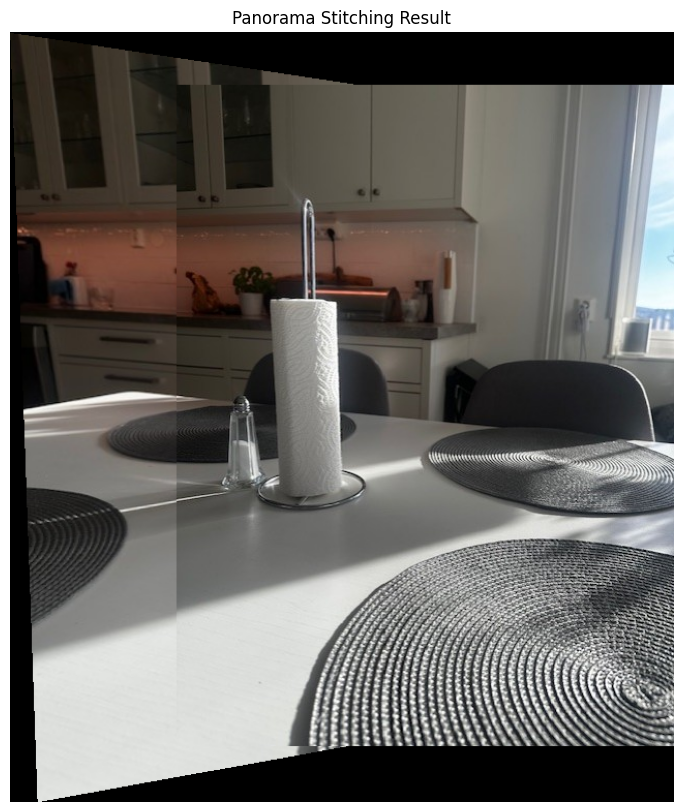

In [ ]:
import matplotlib.pyplot as plt

# display the result
plt.figure(figsize=(15, 10))
plt.imshow(panorama)
plt.title("Panorama Stitching Result")
plt.axis('off')
plt.show()